Classification

 Classification is a type of machine learning algorithm that is used to classify data.

Let's frame it as a classification problem statement.
Converting the Rating from continuous to discrete

In [41]:
# Data
import numpy as np
import pandas as pd
from collections import defaultdict

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# Hide warnings
import warnings
warnings.filterwarnings('ignore')


In [42]:
# Read the cleaned CSV file
df_apps = pd.read_csv(r"../data/Google-Playstore-Dataset-Clean.csv")

# Show the first rows of the DataFrame
print(df_apps.head())

                App Name      Category Installs  Size Minimum Android  \
0                Gakondo     Adventure      10+   10M      7.1 and up   
1    Ampere Battery Info         Tools   5,000+  2.9M      5.0 and up   
2                 Vibook  Productivity      50+  3.7M    4.0.3 and up   
3                 IMOCCI        Social      50+   46M      6.0 and up   
4  The Everyday Calendar     Lifestyle     500+   16M      5.0 and up   

       Released  Last Updated Content Rating  Rating  Minimum Installs  \
0  Feb 26, 2020  Feb 26, 2020       Everyone     0.0                10   
1  May 21, 2020  May 06, 2021       Everyone     4.4               100   
2   Aug 9, 2019  Aug 19, 2019       Everyone     0.0                50   
3  Dec 24, 2018  Dec 20, 2019           Teen     0.0                50   
4  Jun 21, 2019  Jun 21, 2019       Everyone     2.0               500   

   Maximum Installs  
0                15  
1              7662  
2                58  
3                89  
4     

Feature Pruning

We decide to prune the following features:

- App : App names are of no value for the model
- Genres : The informations it stores is same as the feature Category
- Current Ver : Current Version of an app doesn't hold significant value
- Android Ver: Android Version of an app doesn't hold significant value

Step 1 | Data Splitting for Modeling

We split the dataset into 80% train and 20% test.

In [43]:
ignore_columns = ['App Name', 'Released', 'Minimum Android']

# Eliminar las columnas especificadas
df_predic = df_apps.drop(columns=ignore_columns)

# Definir las variables X e Y para la predicción:
x = df_predic.drop(columns=['Rating'])  # Todas las columnas excepto 'Rating' serán variables independientes
y = df_predic['Rating']  # 'Rating' será la variable dependiente, la que se predecira

Label Encoding

In [45]:
# Inicializar LabelEncoder
encoder = LabelEncoder()

# Iterar sobre todas las columnas de combined_data
for column in x.columns:
    if x[column].dtype == 'object':  # Verificar si la columna es de tipo 'object' (categórica)
        x[column + '_encoded'] = encoder.fit_transform(x[column])  # Aplicar Label Encoding

# Eliminar las columnas originales después de la codificación
x_encoded = x.drop(columns=x.select_dtypes(include=['object']).columns)

# Dividir los datos en 80% para entrenamiento y 20% para prueba
x_train_encoded, x_test_encoded, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)


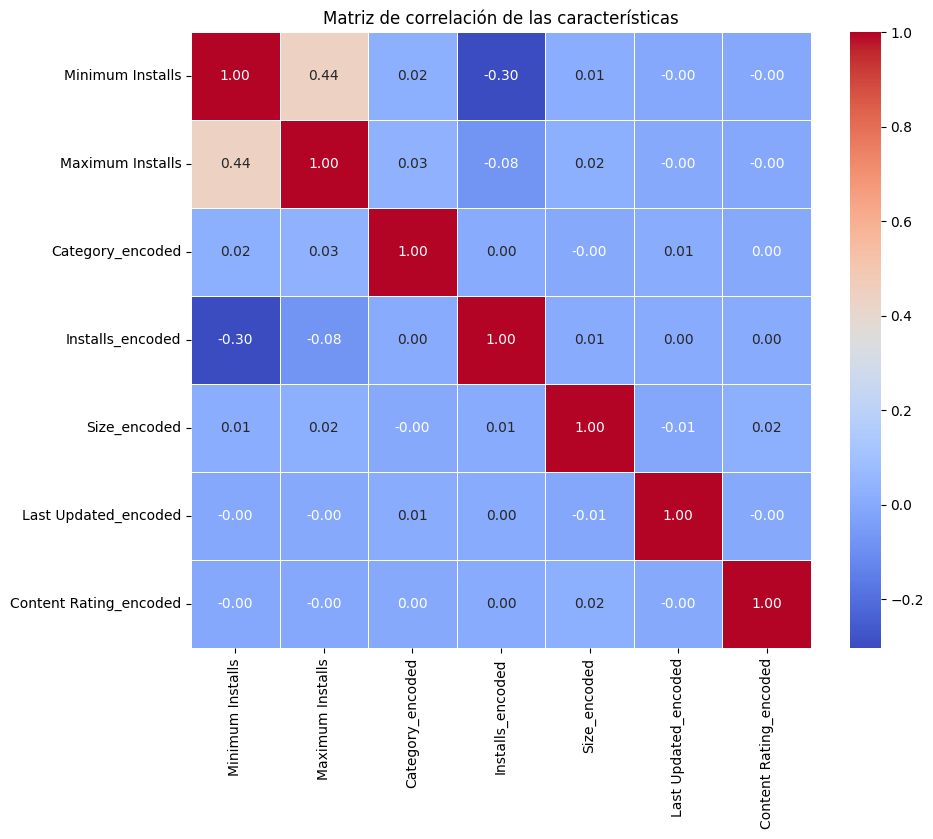

In [46]:
# Calcular la matriz de correlación
correlation_matrix = x_train_encoded.corr()

# Visualizar la matriz de correlación utilizando un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación de las características')
plt.show()


Standardization

In [47]:
# Estandarizar las características
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_test_scaled = scaler.transform(x_test_encoded)


Step 2 | Modeling

In [50]:
y_train_int = y_train.astype(int)
y_test_int = y_test.astype(int)

Creating dataframe for metrics

In [ ]:
models = ['Logistic Regression', 'KNN', 'Random Forest']
datasets = ['train', 'test']

multi_index = pd.MultiIndex.from_product([models, datasets],
                                         names=['model', 'dataset'])

df_metrics_clf = pd.DataFrame(index=multi_index,
                          columns=['accuracy %'])

In [ ]:
df_metrics_clf

Logistic Regression Classifier

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train_int)

In [ ]:
df_metrics_clf.loc['Logistic Regression', 'train'] = lr_clf.score(X_train, y_train_int)
df_metrics_clf.loc['Logistic Regression', 'test'] = lr_clf.score(X_test, y_test_int)

KNeighbors Classifier

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_int)

In [ ]:
df_metrics_clf.loc['KNN', 'train'] = knn_clf.score(X_train, y_train_int)
df_metrics_clf.loc['KNN', 'test'] = knn_clf.score(X_test, y_test_int)

Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train_int)

In [ ]:
df_metrics_clf.loc['Random Forest', 'train'] = rf_clf.score(X_train, y_train_int)
df_metrics_clf.loc['Random Forest', 'test'] = rf_clf.score(X_test, y_test_int)

Classification Evaluation

In [ ]:
# Rounding and coverting the accuracies to percentages
df_metrics_clf['accuracy %'] = df_metrics_clf['accuracy %'].apply(lambda v: round(v*100, ndigits=2))
df_metrics_clf

In [ ]:
data = df_metrics_clf.reset_index()

g = sns.catplot(col='dataset', data=data, kind='bar', x='model', y='accuracy %')

# Adding annotations to bars
# iterate through axes
for ax in g.axes.ravel():
    # add annotations
    for c in ax.containers:
        ax.bar_label(c, label_type='edge')

    ax.margins(y=0.2)

plt.show()